In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" ## Loading pretrained-model with last layer
IMAGE_RES = 224

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

16384/10484 [==============================================] - 0s 0us/step


In [3]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [4]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [5]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [6]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Great Dane', 'clumber', 'Tibetan mastiff',
       'flat-coated retriever', 'dingo', 'Labrador retriever',
       'Egyptian cat', 'tabby', 'Egyptian cat', 'kelpie', 'tabby',
       'American Staffordshire terrier', 'Shih-Tzu', 'tiger cat',
       'German shepherd', 'Egyptian cat', 'Egyptian cat', 'toy terrier',
       'soft-coated wheaten terrier', 'whippet', 'vizsla', 'Egyptian cat',
       'golden retriever', 'Egyptian cat', 'kelpie', 'puck',
       'cocker spaniel', 'Egyptian cat', 'Brittany spaniel', 'tiger cat',
       'Rhodesian ridgeback', 'American Staffordshire terrier'],
      dtype='<U30')

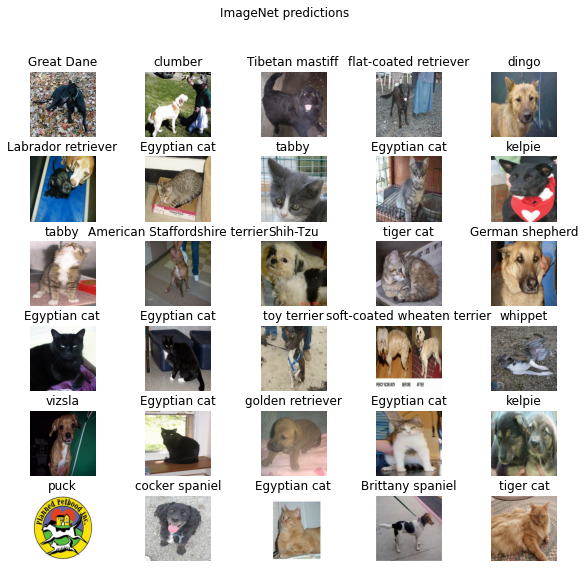

In [7]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [9]:
## You can see that, loading pre-trained model with the last layer, gives us some other output than that of cats and dogs
## Let's load model without last layer
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [10]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [12]:
feature_extractor.trainable = False

In [20]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 108s 186ms/step - loss: 0.0573 - accuracy: 0.9798 - val_loss: 0.0326 - val_accuracy: 0.9899
Epoch 2/6
582/582 [==============================] - 96s 165ms/step - loss: 0.0288 - accuracy: 0.9904 - val_loss: 0.0350 - val_accuracy: 0.9893
Epoch 3/6
582/582 [==============================] - 96s 166ms/step - loss: 0.0249 - accuracy: 0.9910 - val_loss: 0.0295 - val_accuracy: 0.9905
Epoch 4/6
582/582 [==============================] - 97s 167ms/step - loss: 0.0216 - accuracy: 0.9922 - val_loss: 0.0313 - val_accuracy: 0.9903
Epoch 5/6
582/582 [==============================] - 96s 165ms/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 0.0309 - val_accuracy: 0.9901
Epoch 6/6
582/582 [==============================] - 97s 166ms/step - loss: 0.0167 - accuracy: 0.9944 - val_loss: 0.0434 - val_accuracy: 0.9856


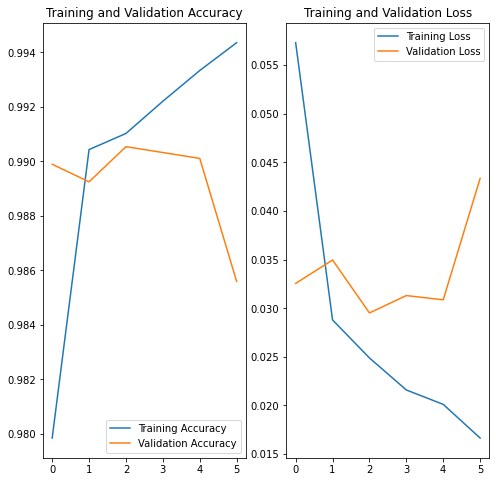

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [24]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat',
       'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog',
       'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog',
       'cat', 'dog', 'cat', 'dog', 'dog'], dtype='<U3')

In [25]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1]
Predicted labels:  [1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1]


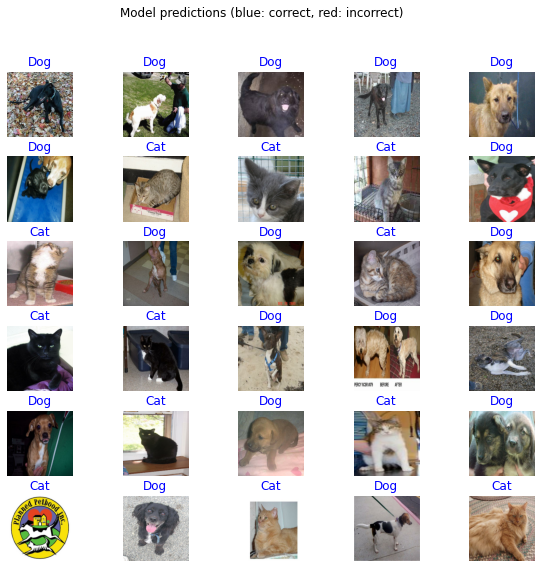

In [26]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")